In [1]:
# Import necessary Python libraries
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
import os
from statistics import stdev

# To do

Add more features to dataframe
- Including total number of frames -> roughly indicates the time (speed) of the btb
    - Requires counting each frame in a magnesis btb sample video
        - Return a list of counts
-  Edit create_samples to deal with new features

Create a new function (or edit find_load_lengths) that creates magnesis btb data if and only if it doesn't already exist in df_clean.csv:
- Import df_clean csv file
- Drop the Unamed : 0 column
- Check if sample_name is in df_clean["sample_name"]
    - If not, process the footage
    - else, proceed to next sample_name

Maybe try dataframes of different video resolution/dimension
- Check to see if data and correlation's remain unchanged based upon the quality of the footage
    - Canm possibly lead to the improvement of runtime

In [2]:
# Raw dataframe initialisation
df_raw = pd.DataFrame(columns = ["sample_name",
                                 "length_of_each_load",
                                 "number_of_loads",
                                 "sum_of_length_of_each_load",
                                 "mean_load_length",
                                 "load_length_deviation",
                                 "shrine_state", 
                                 "length_of_shrine_load_unload"])

In [3]:
# Loop through each file in the Footage folder, get its name + extension and append to an array
def get_sample_names_and_shrine_states():
    """
    This funbction returns the file names of each magnesis btb sample, and the state of the shrine

    :returns: Tuple including file_names, shrine_states
    """

    file_names = []
    shrine_states = []
    for file_name in os.listdir("Footage/Trimmed/"):
        if file_name.endswith(".mp4"): 
            file_names.append(file_name)
            if (file_name.split("_")[2] == "unloaded.mp4"):
                shrine_states.append(1)
            elif (file_name.split("_")[2] == "loaded.mp4"):
                shrine_states.append(0)
            else:
                print("incorrect file name: " + file_name)
    return (file_names, shrine_states)

# Loop through every magnesis btb sample
# Read the footage and append each frame
# Count the number of load frames for each load
# This will take a very long time to load
def find_load_lengths(sample_names, dim):
    """
    This function finds the number of frames of world loads in each continuous world load

    :returns: Lengths of each load
    """
    load_lengths = []
    for sample_name in sample_names:
        capture = cv2.VideoCapture("Footage/Trimmed/" + sample_name)
        capture.set(3, dim[0])
        capture.set(4, dim[1])
        success, img = capture.read()
        print(success)
        f_num = 0
        frames = []
        total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_rate = total_frames
    
        # Loop through every frame in the sample and append it to the "frames" array, check similarity of previous frame
        sum_load = 0
        loads = []
        for f_num in range(0, total_frames, 1):
            #print(sample_name, str(f_num), str(round(f_num/total_frames * 100, 1)) + "%")
            capture.set(cv2.CAP_PROP_POS_FRAMES, f_num)
            _, image = capture.read()
            resize = cv2.resize(image, (dim[0], dim[1]))
            frames.append(resize)
            
            if (f_num != 0):
                #print("ssim of " + str(f_num) + " " + str(f_num - 1) + " is: " + str(ssim(frames[f_num-1], frames[f_num], multichannel = True)))
                if (ssim(frames[f_num], frames[f_num-1], multichannel = True) >= 0.95):
                    sum_load += 1
                elif (sum_load != 0):
                    loads.append(sum_load + 1)
                    sum_load = 0
                else:
                    sum_load = 0
        load_lengths.append(loads)
    return load_lengths                

def create_samples(df, names, lengths, states):
    """
    This functions creates magnesis btb samples, appending them to an array

    :returns: Dataframe including each magnesis btb sample
    """

    series = []
    for i in range(len(names)):
        series.append([names[i], lengths[i], len(lengths[i]), sum(lengths[i]), sum(lengths[i])/len(lengths[i]),
                            stdev(lengths[i]), states[i], lengths[i][-1]])
        #print(series)
    df = pd.DataFrame(series, columns = df.columns)
    return df

Create Dataframe for analysis

In [4]:
dimension = [640, 480]
btb_sample_names, magnesis_shrine_states = get_sample_names_and_shrine_states()
world_load_lengths = find_load_lengths(btb_sample_names, dimension)
df_clean = create_samples(df_raw, btb_sample_names, world_load_lengths, magnesis_shrine_states)
df_clean.to_csv("df_clean.csv")

True
True
True
True
True
True
True
True
True
True
True


In [5]:
df_clean

,sample_name,length_of_each_load,number_of_loads,sum_of_length_of_each_load,mean_load_length,load_length_deviation,shrine_state,length_of_shrine_load_unload
0,magnesis_btb0_loaded.mp4,"[71, 5, 89, 37, 29, 6, 2]",7,239,34.142857,34.343503,0,2
1,magnesis_btb10_loaded.mp4,"[44, 4, 4, 63, 85, 4, 4]",7,208,29.714286,34.189249,0,4
2,magnesis_btb1_loaded.mp4,"[56, 4, 13, 72, 44, 9, 9, 31, 10, 3]",10,251,25.100000,24.433356,0,3
3,magnesis_btb2_loaded.mp4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 51, 2, 2, 2, 4,...",24,240,10.000000,18.582367,0,9
4,magnesis_btb3_loaded.mp4,"[21, 44, 13, 7, 120, 49, 8, 3, 28, 8, 12]",11,313,28.454545,33.992245,0,12
5,magnesis_btb4_loaded.mp4,"[60, 27, 7, 33, 75, 24, 17, 5, 18, 12, 2, 2]",12,282,23.500000,23.023703,0,2
6,magnesis_btb5_loaded.mp4,"[62, 13, 85, 49, 6, 21, 3, 10, 6, 3]",10,258,25.800000,29.085315,0,3
7,magnesis_btb6_unloaded.mp4,"[31, 14, 6, 21, 28, 69, 42, 5, 7, 12, 13, 4]",12,252,21.000000,19.197538,1,4
8,magnesis_btb7_loaded.mp4,"[7, 20, 50, 100, 41, 19, 24, 6]",8,267,33.375000,30.918961,0,6
9,magnesis_btb8_loaded.mp4,"[68, 17, 3, 86, 72, 32, 23, 14, 3, 4]",10,322,32.200000,31.460028,0,4


In [6]:
corr = df_clean.corr()
corr.style.background_gradient(cmap="coolwarm")

,number_of_loads,sum_of_length_of_each_load,mean_load_length,load_length_deviation,shrine_state,length_of_shrine_load_unload
number_of_loads,1.000000,-0.001272,-0.900492,-0.704106,0.071362,0.460960
sum_of_length_of_each_load,-0.001272,1.000000,0.246037,0.049816,-0.085540,0.302867
mean_load_length,-0.900492,0.246037,1.000000,0.762220,-0.245074,-0.278563
load_length_deviation,-0.704106,0.049816,0.762220,1.000000,-0.500657,0.040660
shrine_state,0.071362,-0.085540,-0.245074,-0.500657,1.000000,-0.097870
length_of_shrine_load_unload,0.460960,0.302867,-0.278563,0.040660,-0.097870,1.000000


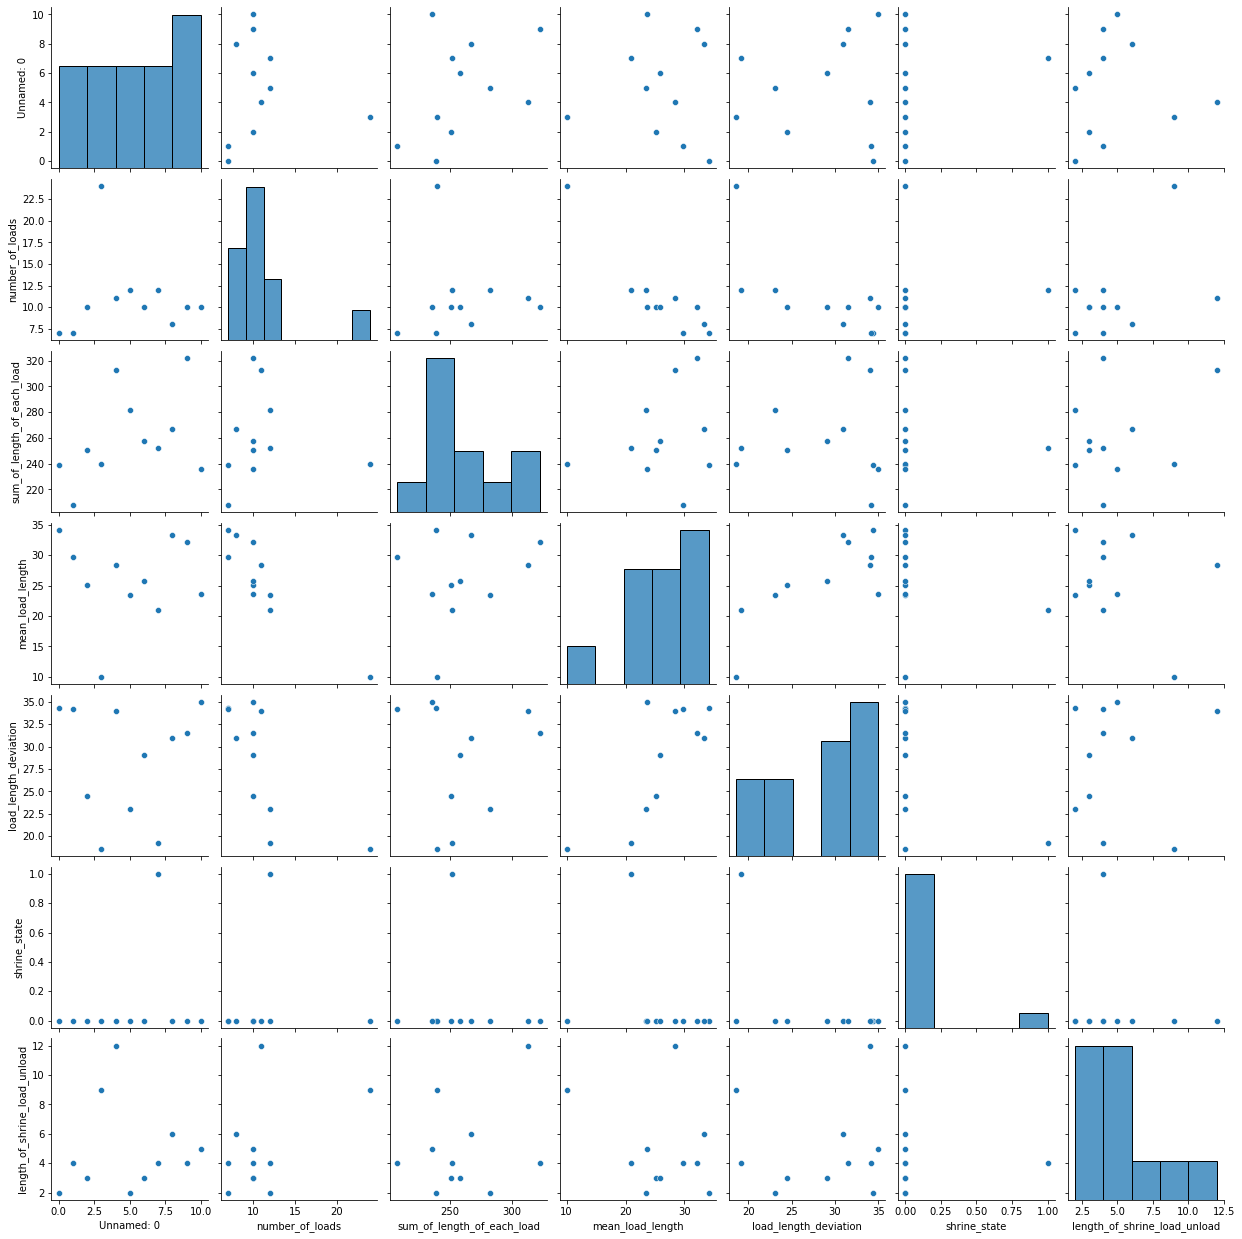

In [7]:
import pandas as pd
import seaborn as sns

df_testing = pd.read_csv("df_clean.csv")

sns.pairplot(df_testing)

In [8]:
def convert_frames_to_seconds(df, frame_rate):
    """
    This function converts the frame data of a dataframe into seconds
    
    :returns: Dataframe with time data
    """

    pass